<a href="https://colab.research.google.com/github/Chaelsy-kim/Capstone_Design/blob/main/FinalResult/Analysis_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt
from torchvision import models
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
NUM_EPOCHS = 5
LR = 0.0001 # Learning Rate

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

mtest_path = '/content/drive/MyDrive/dah2/test/metal/'
wtest_path = '/content/drive/MyDrive/dah2/test/wood/'
mtrain_path = '/content/drive/MyDrive/dah2/train/metal/'
wtrain_path = '/content/drive/MyDrive/dah2/train/wood/'
mvalid_path = '/content/drive/MyDrive/dah2/valid/metal/'
wvalid_path = '/content/drive/MyDrive/dah2/valid/wood/'

In [ ]:
mtest_file = sorted([os.path.join(mtest_path, f) for f in os.listdir(mtest_path)])
wtest_file = sorted([os.path.join(wtest_path, f) for f in os.listdir(wtest_path)])

mtrain_file = sorted([os.path.join(mtrain_path, f) for f in os.listdir(mtrain_path)])
wtrain_file = sorted([os.path.join(wtrain_path, f) for f in os.listdir(wtrain_path)])

mvalid_file = sorted([os.path.join(mvalid_path, f) for f in os.listdir(mvalid_path)])
wvalid_file = sorted([os.path.join(wvalid_path, f) for f in os.listdir(wvalid_path)])

filepath1 = [*wtest_file, *mtest_file]
filepath2 = [*wtrain_file, *mtrain_file]
filepath3 = [*wvalid_file, *mvalid_file]

test_image = [i for i in filepath1 if cv2.imread(i) is not None]
train_image = [i for i in filepath2 if cv2.imread(i) is not None]
valid_image = [i for i in filepath3 if cv2.imread(i) is not None]

random.seed(10)
print(len(test_image),len(train_image),len(valid_image))
#random.shuffle(test_file)
#random.shuffle(train_file)
#random.shuffle(valid_file)

20 2526 984


In [ ]:
class ImageTransform() : 
    def __init__(self, resize, mean, std) :
        self.data_transform = {
            'train' : transforms.Compose([
                    transforms.Resize((64,64)),
                    #transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                # scale=(0.5, 1.0) : 랜덤 크기 50~100% 리사이징
                    #transforms.RandomHorizontalFlip(), # 수평 반전
                    transforms.ToTensor(), # (H, W, C) --> (C, H, W)
                    #transforms.Normalize(mean ,std) # 정규화
                # mean (0.485, 0.456, 0.406), std (0.229, 0.224, 0.225)
                # ---> ImageNet의 이미지 RGB 채널마다 평균과 표준편차를 의미
            ]),
            'val' : transforms.Compose([
                    transforms.Resize((64,64)),
                    #transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    #transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase) :
        return self.data_transform[phase](img)

In [ ]:
class mwdataset(Dataset) :
    def __init__(self, file_list, transform=None, phase='train') :
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self) :
        return len(self.file_list)
    
    def __getitem__(self, idx) :
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        label = img_path.split('/')[-2].split('.')[0]
        if label == 'metal' :
            label = 0
        elif label == 'wood' :
            label = 1
        return img_transformed, label

In [ ]:
batch_size = 32
train_dataset = mwdataset(train_image, transform = ImageTransform(0,0,0), phase = 'train')
valid_dataset = mwdataset(valid_image, transform = ImageTransform(0,0,0), phase = 'val')

print(train_dataset.__getitem__(0)[0].size())
print(valid_dataset.__getitem__(0)[0].size())
print(train_dataset.__len__)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
dataloader_dict = {'train':train_dataloader, 'val':valid_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
<bound method mwdataset.__len__ of <__main__.mwdataset object at 0x7f3a721a1a50>>
torch.Size([32, 3, 64, 64])
tensor([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 1])


In [ ]:
train_dataloader, valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f3a7213bc50>,
 <torch.utils.data.dataloader.DataLoader at 0x7f3a721a1950>)

In [ ]:
model = models.alexnet(num_classes = 2)
model.eval()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
import torchsummary

torchsummary.summary(model, input_size=(3, 640, 640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 159, 159]          23,296
              ReLU-2         [-1, 64, 159, 159]               0
         MaxPool2d-3           [-1, 64, 79, 79]               0
            Conv2d-4          [-1, 192, 79, 79]         307,392
              ReLU-5          [-1, 192, 79, 79]               0
         MaxPool2d-6          [-1, 192, 39, 39]               0
            Conv2d-7          [-1, 384, 39, 39]         663,936
              ReLU-8          [-1, 384, 39, 39]               0
            Conv2d-9          [-1, 256, 39, 39]         884,992
             ReLU-10          [-1, 256, 39, 39]               0
           Conv2d-11          [-1, 256, 39, 39]         590,080
             ReLU-12          [-1, 256, 39, 39]               0
        MaxPool2d-13          [-1, 256, 19, 19]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_size = 0
    running_loss = 0
    corr = 0
    
    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습을 시작합니다.
    for batch_idx, (img, lbl) in enumerate(prograss_bar, start=1):
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)
        
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()
        
        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)
        
        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()
        
        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()
        
        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)
        running_size += img.size(0)
        prograss_bar.set_description(f'[Training] loss: {running_loss / running_size:.4f}, accuracy: {corr / running_size:.4f}')
        
    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [ ]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        
        # 배치별 evaluation을 진행합니다.
        for img, lbl in data_loader:
            # device에 데이터를 올립니다.
            img, lbl = img.to(device), lbl.to(device)
            
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * img.size(0)
        
        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)
        
        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [ ]:
min_loss = np.inf

for epoch in range(NUM_EPOCHS):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_dataloader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, valid_dataloader, loss_fn, device)   
    
    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
    
    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO] val_loss has been improved from inf to 0.86499. Saving Model!
epoch 01, loss: 0.67108, acc: 0.59343, val_loss: 0.86499, val_accuracy: 0.00000


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO] val_loss has been improved from 0.86499 to 0.75313. Saving Model!
epoch 02, loss: 0.65622, acc: 0.59105, val_loss: 0.75313, val_accuracy: 0.62398


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 03, loss: 0.61154, acc: 0.65598, val_loss: 1.02546, val_accuracy: 0.23679


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 04, loss: 0.56166, acc: 0.69873, val_loss: 1.11778, val_accuracy: 0.48476


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 05, loss: 0.51956, acc: 0.73634, val_loss: 1.07989, val_accuracy: 0.57520


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 06, loss: 0.52515, acc: 0.73911, val_loss: 1.14506, val_accuracy: 0.47256


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 07, loss: 0.39901, acc: 0.81789, val_loss: 1.15042, val_accuracy: 0.54370


  0%|          | 0/79 [00:00<?, ?it/s]

[INFO] val_loss has been improved from 0.75313 to 0.36570. Saving Model!
epoch 08, loss: 0.38215, acc: 0.82858, val_loss: 0.36570, val_accuracy: 0.85467


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 09, loss: 0.28532, acc: 0.88401, val_loss: 1.44144, val_accuracy: 0.44715


  0%|          | 0/79 [00:00<?, ?it/s]

epoch 10, loss: 0.18056, acc: 0.93112, val_loss: 1.48739, val_accuracy: 0.53354


In [ ]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
          

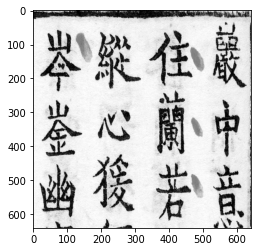

In [ ]:
# 간단한 샘플 사진, 학습시킨 이미지와 다르게 해봤음

img = get_image("/content/drive/MyDrive/dah/test/metal/---------_--_2_026--2-_jpg.rf.2da0b26759d143160b2311e01e56c5e6.jpg")
plt.imshow(img)
img2 = get_image("/content/drive/MyDrive/dah/test/wood/---------_--_2_032--3-_jpg.rf.157dad1c21ae52e9fe76a2f600b2fa64.jpg")
plt.imshow(img2)

In [ ]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256,256))
    ])    

    return transf

def get_preprocess_transform():
    #normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])    
    #train할때 normalize안해서 지워놓았음. 

    transf = transforms.Compose([
        transforms.ToTensor()
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [ ]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
test_pred = batch_predict([pill_transf(img),pill_transf(img2)]) # 0: metal, 1: wood
test_pred

array([[0.44621506, 0.55378497],
       [0.15595245, 0.84404755]], dtype=float32)

In [ ]:
a = np.array([pill_transf(img),pill_transf(img2)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
!pip install lime
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/1000 [00:00<?, ?it/s]

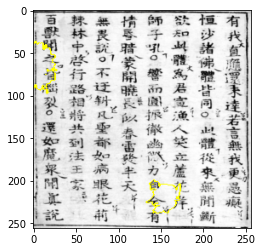

In [ ]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)


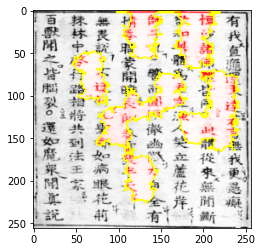

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)